# Deep Dream Implementation on MNIST using PyTorch Hooks


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as T

import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d 
import matplotlib.pyplot as plt
import tqdm


In [2]:
# paths
MNIST_PATH = 'data/' # wherever you have manually downloaded the MNIST dataset .tar and unzipped it

In [3]:
# metadata
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
MNIST_DIMS = (28,28)

# config
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1024

# transforms
process_image = T.Compose([
    T.ToTensor(),
    T.Normalize((MNIST_MEAN,), (MNIST_STD,)) 
])

# data
train_dataset = torchvision.datasets.MNIST(
    MNIST_PATH, 
    train=True,
    transform=process_image
)
test_dataset = torchvision.datasets.MNIST(
    MNIST_PATH, 
    train=False, 
    transform=process_image
)

# data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_TRAIN, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_TEST, 
    shuffle=True)


Label: tensor(4)


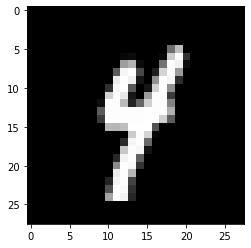

In [4]:
_, (example_data, labels) = next(enumerate(test_loader))
sample = example_data[0][0]
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))


In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm.notebook.tqdm(train_loader, total=int(len(train_loader)))
    for i, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        tk0.set_postfix(loss=(loss.item()*data.size(0) / ((i+1) * train_loader.batch_size)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print(f"\nTest set: Average loss: {round(test_loss, 4)}, Accuracy: {correct}/{len(test_loader.dataset)} ({100.*correct/len(test_loader.dataset)}%)\n")
    

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(64, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

In [7]:
# config
DEVICE = "cpu"
LR = 1.e-2
MOMENTUM = 5.e-1
EPOCHS = 2

# train & test
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LR,
                      momentum=MOMENTUM)
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)
    

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1172, Accuracy: 9633/10000 (96.33%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9763/10000 (97.63%)



In [8]:
def deprocess_tensor(img, should_rescale=True): 
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0], std=[1.0 / MNIST_STD]),
        T.Normalize(mean=[-MNIST_MEAN], std=[1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max() 
    x_rescaled = (x - low) / (high - low) 
    return x_rescaled

def jitter(X, x_jitter, y_jitter): 
    if x_jitter != 0:
        left = X[:, :, :, :-x_jitter]
        right = X[:, :, :, -x_jitter:]
        X = torch.cat([right, left], dim=3)
    if y_jitter != 0:
        top = X[:, :, :-y_jitter]
        bottom = X[:, :, -y_jitter:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2) 
    X_np = gaussian_filter1d(X_np, sigma, axis=3) 
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X


In [9]:
class Hook():
    def __init__(self, module, backward=False):
        if backward:
            self.hook = module.register_backard_hook(self.hook_fn)
        else:
            self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.module = module
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()


In [10]:
def dream(model, hook, slices, learning_rate=1.e0, num_iterations=500, l2_reg=1.e-3, blur_every=10, max_jitter=3, show_every=100, show_first_image=True, show=True):
    # turn on evaluation mode
    model.eval()

    # get random image tensor
    img = torch.randn(1, 1, MNIST_DIMS[0], MNIST_DIMS[1]).type(torch.FloatTensor).requires_grad_() # initialize image

    for t in range(num_iterations):
        # jitter image
        x_jitter, y_jitter = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, x_jitter, y_jitter))

        # feed image through network, backpropagate with respect to hook output, and update image using gradient of image
        out = model(img)
        score = hook.output[slices].sum() - (l2_reg * torch.norm(img))
        score.backward()
        img.data += (learning_rate*img.grad.data/torch.norm(img.grad.data))
        img.grad.data.zero_()

        # undo jitter
        img.data.copy_(jitter(img.data, -x_jitter, -y_jitter))

        # clamp and blur the image for regularization
        low = float(-MNIST_MEAN / MNIST_STD)
        high = float((1.0 - MNIST_MEAN) / MNIST_STD) 
        img.data.clamp_(min=low, max=high)
        if t % blur_every == 0: 
            blur_image(img.data, sigma=0.5)
            
        # show image
        if show:
            if (t == 0 and show_first_image) or ((t + 1) % show_every == 0) or (t == num_iterations - 1): 
                plt.imshow(deprocess_tensor(img.data.clone().cpu()), cmap="gray")
                plt.title(f"Iteration {t+1} / {num_iterations}") 
                plt.gcf().set_size_inches(4, 4)
                plt.axis("off")
                plt.show()

    return deprocess_tensor(img.data.cpu())


In [11]:
def get_conv_output_image_shape(conv_module, input_shape):
    return tuple([
        int(((input_shape[i] - conv_module.kernel_size[i] + (2*conv_module.padding[i])) / conv_module.stride[i]) + 1)
        for i in range(len(input_shape))
    ])

conv1_output_image_shape = get_conv_output_image_shape(model.conv1, MNIST_DIMS)
conv2_output_image_shape = get_conv_output_image_shape(model.conv2, conv1_output_image_shape)
conv3_output_image_shape = get_conv_output_image_shape(model.conv3, conv2_output_image_shape)


# Output of 1st convolutional layer

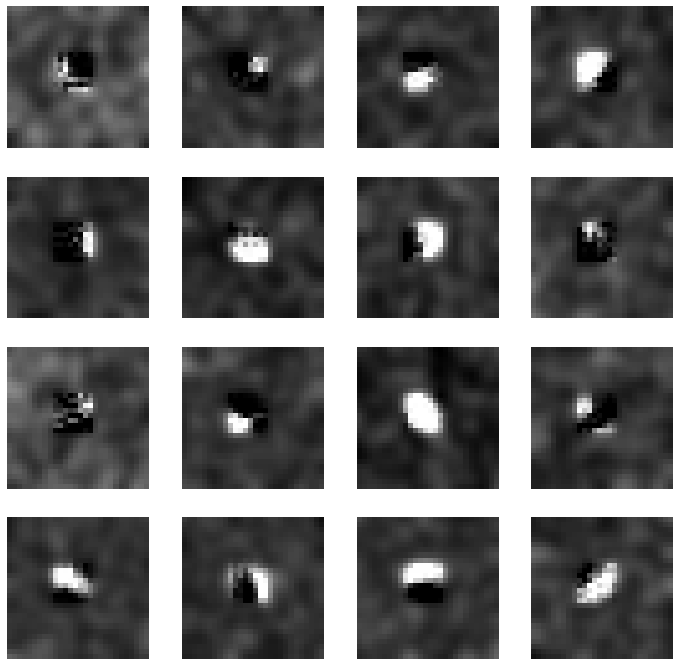

In [12]:
module = model.conv1
num_channels = module.out_channels

hook = Hook(module)

middle_height = int(conv1_output_image_shape[0]/2)
middle_width = int(conv1_output_image_shape[1]/2)

num_rows = 4
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,12))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
        slice(middle_height, middle_height+1),
        slice(middle_width, middle_width+1),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=100, 
        l2_reg=1.e-3, 
        blur_every=10, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")
    

# Output of 2nd convolutional layer

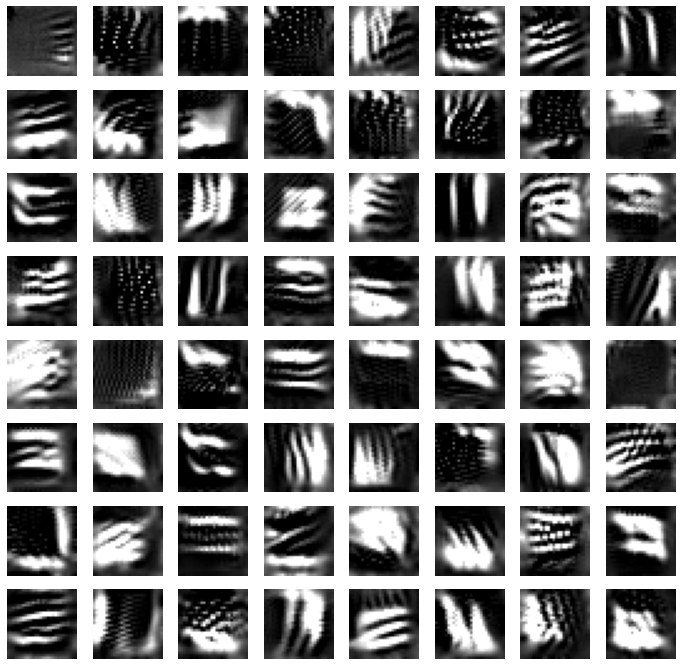

In [13]:
module = model.conv2
num_channels = module.out_channels

hook = Hook(module)

num_rows = 8
num_cols = 8
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,12))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
        slice(None),
        slice(None),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=100, 
        l2_reg=1.e-3, 
        blur_every=10, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")
    

# Output of 3rd convolutional layer

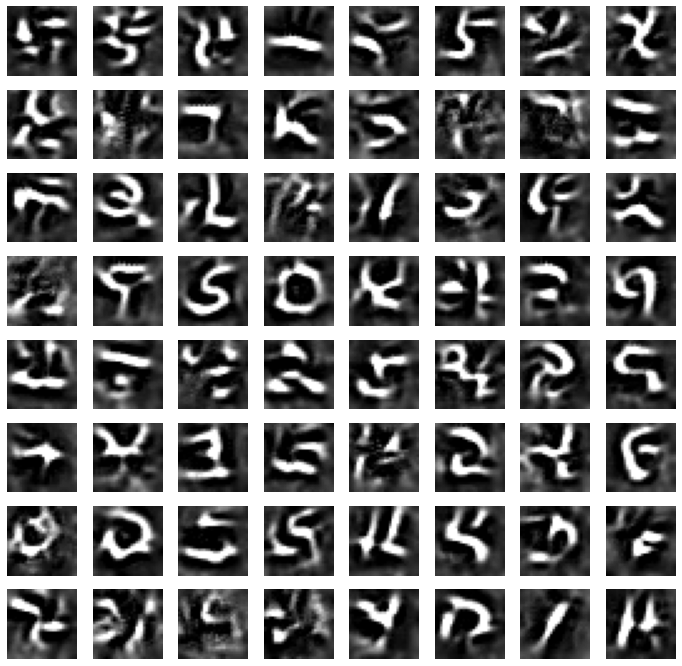

In [14]:
module = model.conv3
num_channels = module.out_channels

hook = Hook(module)

num_rows = 8
num_cols = 8
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,12))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
        slice(None),
        slice(None),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=100, 
        l2_reg=1.e-3, 
        blur_every=10, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")
    

# Output of 1st fully connected layer

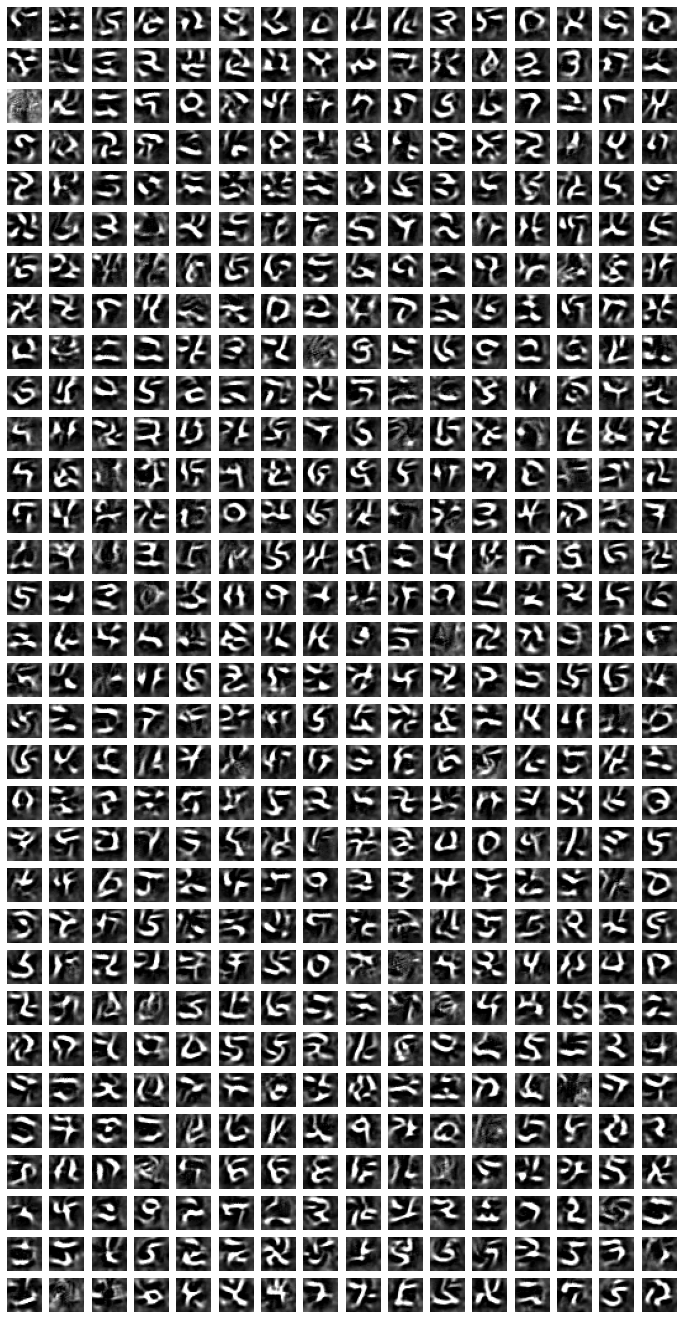

In [15]:
module = model.fc1
num_channels = module.out_features

hook = Hook(module)

num_rows = 32
num_cols = 16
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,24))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=100, 
        l2_reg=1.e-3, 
        blur_every=10, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")


# Output of 2nd fully connected layer

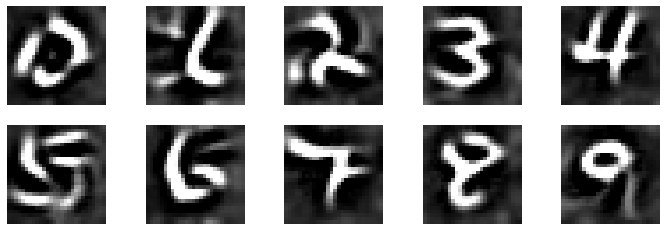

In [16]:
module = model.fc2
num_channels = module.out_features

hook = Hook(module)

num_rows = 2
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,4))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=100, 
        l2_reg=1.e-3, 
        blur_every=10, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")

# Output of entire network (including log softmax)

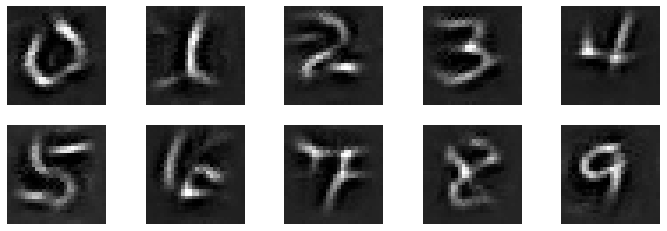

In [17]:
module = model
num_channels = 10

hook = Hook(module)

num_rows = 2
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,4))

for channel in range(num_channels):
    slices = [
        slice(None), 
        slice(channel,channel+1),
    ]
    
    image = dream(
        model,
        hook,
        slices,
        learning_rate=1., 
        num_iterations=500, 
        l2_reg=1.e-3, 
        blur_every=100, 
        max_jitter=3, 
        show=False
    )
    x_axis = int(channel/num_cols)
    y_axis = channel % num_cols
    axes[x_axis,y_axis].set_axis_off()
    axes[x_axis,y_axis].imshow(image, cmap="gray")